In [0]:
!pip install http://download.pytorch.org/whl/cu92/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

In [4]:
!nvidia-smi

Sat Mar 28 04:17:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

In [0]:
# normalize the image 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
           'Sneaker','Bag','Ankle_boot')

 Coat     Dress     T-shirt     Pullover


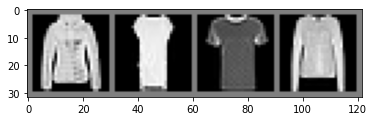

In [7]:
# functions to show an image
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accuracy(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training accuracy", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation accuracy", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.title("Evolution of the training and validation accuracy")
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('     '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
        # self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x shape is (batchsize, 1, 28, 28)
        # 1x28x28 -> 32x14x14
        x = self.pool(F.relu(self.conv1(x)))
        # 32x14x14 -> 32x7x7
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [9]:
seed=42
if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device=', device)

device= cuda


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 50000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 10000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

num_workers = 2
test_batch_size = 4
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-3)
    return criterion, optimizer

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=val_sampler,
                                          num_workers=num_workers)

In [0]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []
    train_accu_history = []
    val_accu_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        

        # get training accuracy
        correct = 0
        total = 0
        with torch.no_grad():
          for inputs, labels in train_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              predictions = net(inputs)
              _, predicted = torch.max(predictions.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
        train_accu_history.append(100 * correct / total)
        print('Training accuracy = {:.2f}%'.format(100 * correct / total))
        
        
        # Validation
        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        correct = 0
        total = 0
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()

              _, predicted = torch.max(predictions.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        val_history.append(total_val_loss / len(val_loader))
        val_accu_history.append(100 * correct / total)

        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        print('Validation accuracy = {:.2f}%'.format(100 * correct / total))


        # Training
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()
        train_history.append(total_train_loss / len(train_loader))
    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history, train_accu_history, val_accu_history

In [0]:
net = Net()
train_history, val_history, train_accu_history, val_accu_history \
= train(net, batch_size=64, n_epochs=40, learning_rate=0.0007)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 40
learning_rate= 0.0007
Training accuracy = 9.87%
Validation loss = 2.30
Validation accuracy = 9.94%
Epoch 1, 10% 	 train_loss: 1.13 took: 10.81s
Epoch 1, 20% 	 train_loss: 0.59 took: 1.08s
Epoch 1, 30% 	 train_loss: 0.53 took: 0.95s
Epoch 1, 40% 	 train_loss: 0.51 took: 1.08s
Epoch 1, 50% 	 train_loss: 0.45 took: 1.11s
Epoch 1, 60% 	 train_loss: 0.42 took: 1.05s
Epoch 1, 70% 	 train_loss: 0.41 took: 1.05s
Epoch 1, 80% 	 train_loss: 0.40 took: 1.12s
Epoch 1, 90% 	 train_loss: 0.39 took: 1.11s
Training accuracy = 88.12%
Validation loss = 0.35
Validation accuracy = 87.10%
Epoch 2, 10% 	 train_loss: 0.37 took: 10.62s
Epoch 2, 20% 	 train_loss: 0.32 took: 1.06s
Epoch 2, 30% 	 train_loss: 0.33 took: 1.08s
Epoch 2, 40% 	 train_loss: 0.34 took: 1.10s
Epoch 2, 50% 	 train_loss: 0.35 took: 1.09s
Epoch 2, 60% 	 train_loss: 0.34 took: 1.04s
Epoch 2, 70% 	 train_loss: 0.33 took: 1.04s
Epoch 2, 80% 	 train_loss: 0.31 took: 1.05s
Epoch 2, 90% 	 t

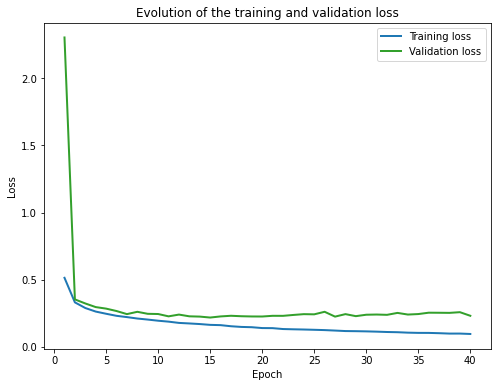

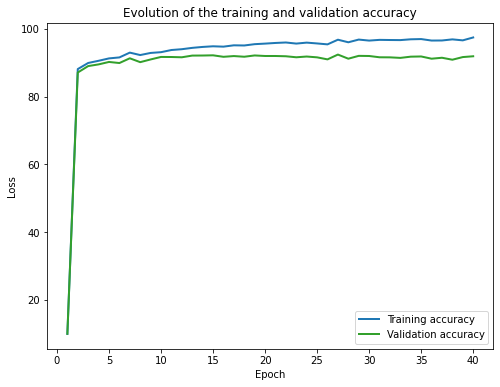

In [0]:
plot_losses(train_history, val_history)
plot_accuracy(train_accu_history, val_accu_history)

In [0]:
net = Net()
net.load_state_dict(torch.load('best_model.pth'))
net = net.to(device)

In [0]:
correct_imgs_dict = dict((i, []) for i in range(len(classes)))
wrong_imgs_dict = dict((i, []) for i in range(len(classes)))
wrong_labels_dict = dict((i, []) for i in range(len(classes)))
break_flag = False
loader_iter = iter(testloader)
while not break_flag:
  # print(sum([len(list(correct_imgs_dict.values())[i]) for i in range(10)]))
  # print(sum([len(list(wrong_imgs_dict.values())[i]) for i in range(10)]))
  images, labels = loader_iter.__next__()
  outputs = net(images.to(device))
  _, predicts = torch.max(outputs, 1)
  for img, label, predict in zip(images, labels, predicts):
    img = img.numpy()
    label = label.item()
    predict = predict.item()
    if predict == label and len(correct_imgs_dict[label]) < 2:
      correct_imgs_dict[label].append(img)
    if predict != label and len(wrong_imgs_dict[label]) < 2:
      wrong_imgs_dict[label].append(img)
      wrong_labels_dict[label].append(predict)
    if sum([len(list(correct_imgs_dict.values())[i]) for i in range(10)]) == 20 \
    and sum([len(list(wrong_imgs_dict.values())[i]) for i in range(10)]) == 20:
      break_flag = True

In [0]:
print(sum([len(list(correct_imgs_dict.values())[i]) for i in range(10)]))
print(sum([len(list(wrong_imgs_dict.values())[i]) for i in range(10)]))

20
20


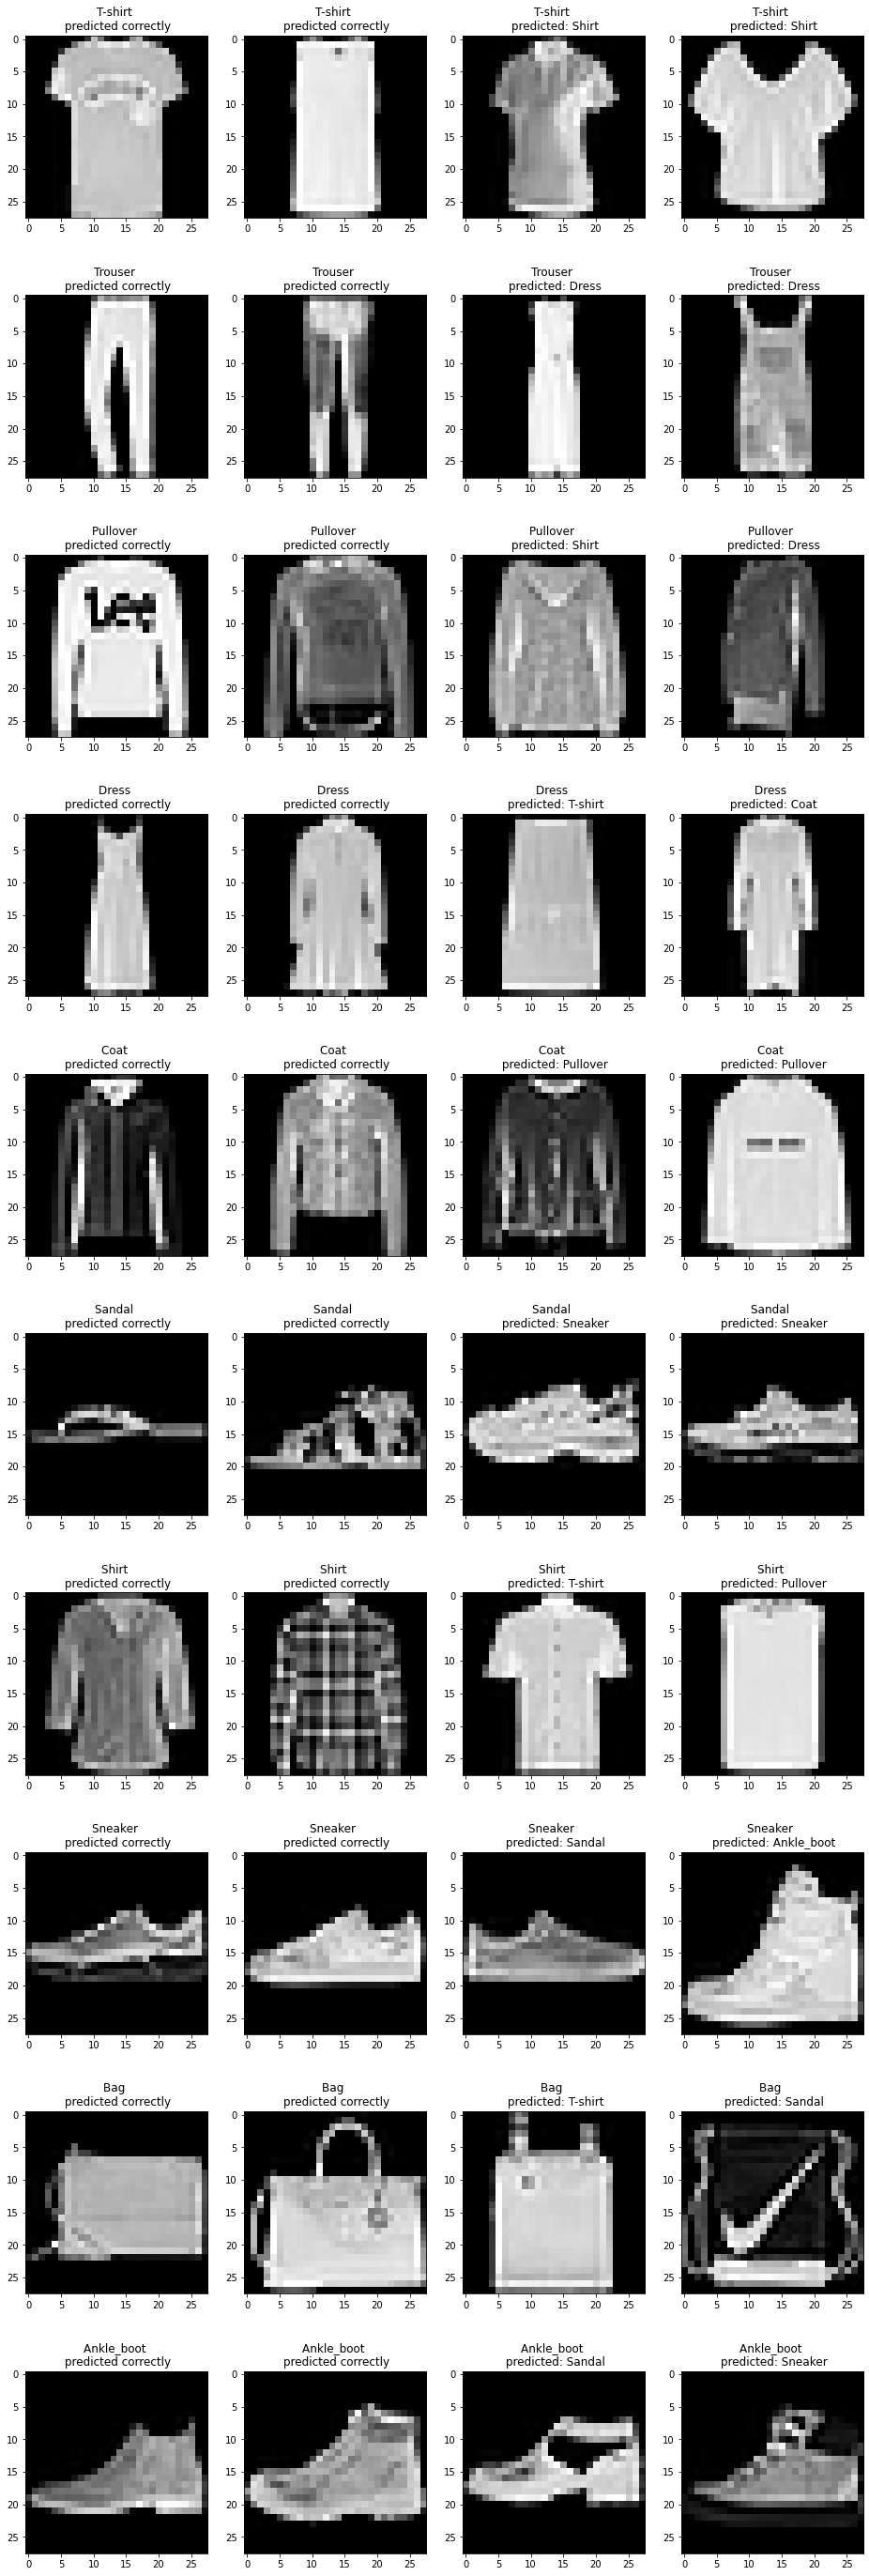

In [0]:
plt.figure(figsize=(16, 50))
# print(correct_imgs_dict.keys())
for i in range(len(classes)):
    # print(correct_imgs_dict[i])
    plt.subplot(10, 4, i*4+1)
    plt.imshow(correct_imgs_dict[i][0].reshape((28, 28)), cmap='gray')
    plt.title('%s \n predicted correctly' % (classes[i]))
    plt.subplot(10, 4, i*4+2)
    plt.imshow(correct_imgs_dict[i][1].reshape((28, 28)), cmap='gray')
    plt.title('%s \n predicted correctly' % (classes[i]))
    plt.subplot(10, 4, i*4+3)
    plt.imshow(wrong_imgs_dict[i][0].reshape((28, 28)), cmap='gray')
    plt.title('%s \n predicted: %s' % (classes[i], classes[wrong_labels_dict[i][0]]))
    plt.subplot(10, 4, i*4+4)
    plt.imshow(wrong_imgs_dict[i][1].reshape((28, 28)), cmap='gray')
    plt.title('%s \n predicted: %s' % (classes[i], classes[wrong_labels_dict[i][1]]))

(32, 1, 5, 5) (32, 32, 5, 5)


(-0.5, 4.5, 4.5, -0.5)

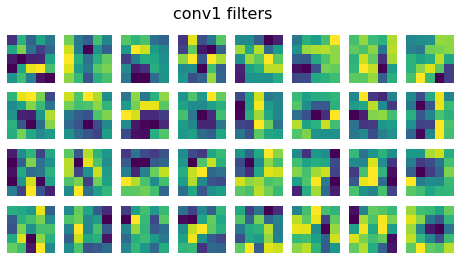

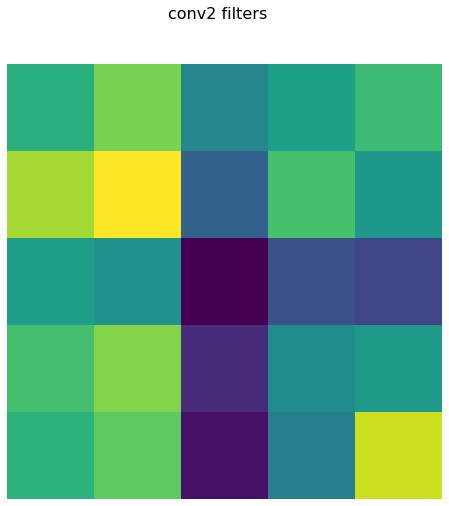

In [15]:
conv1 = net.conv1.cpu().weight.data.numpy()
conv2 = net.conv2.cpu().weight.data.numpy()
print(conv1.shape, conv2.shape)
fig = plt.figure(figsize=(8, 4))
fig.suptitle('conv1 filters', fontsize=16)
for i in range(conv1.shape[0]):
  plt.subplot(4, 8, i+1)
  im = conv1[i].reshape((5, 5))
  plt.imshow((im - im.min()) / (im.max() - im.min()))
  plt.axis('off')

fig = plt.figure(figsize=(8, 8))
fig.suptitle('conv2 filters', fontsize=16)
im = np.sum(np.sum(conv2, axis=0), axis=0).reshape((5, 5))
plt.imshow((im - im.min()) / (im.max() - im.min()))
plt.axis('off')

Ground truth:

Ankle_boot   Pullover    Trouser    Trouser


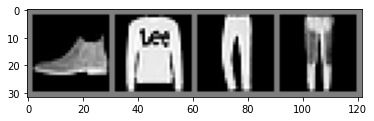

In [0]:
try:
  images, labels = next(iter(testloader))
except EOFError:
  pass

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

Predicted:

Ankle_boot   Pullover    Trouser    Trouser


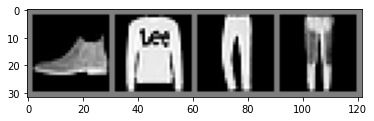

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images_cuda,labels_cuda = images.to(device),labels.to(device)
        outputs = net(images_cuda)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_cuda).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [0]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in testloader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
T-shirt      83.50   
Trouser      98.30   
Pullover     90.00   
Dress        92.30   
Coat         91.00   
Sandal       98.10   
Shirt        71.60   
Sneaker      98.40   
Bag          97.80   
Ankle_boot   95.00   
